# Brain Tumor Classification

In this project, we will be classifying different types of brain tumors using a deep learning model. We will specifically be using the Vision Transformer Model to classify these images. 

In [39]:
!pip install imbalanced-learn
!pip install tensorflow-addons

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import os
from PIL import Image
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from keras.preprocessing.image import img_to_array
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split

In [42]:
tumor = [('glioma_tumor', 0),('meningioma_tumor', 1),('no_tumor', 2),('pituitary_tumor', 3)]
path1 = '/content/drive/My Drive/Colab Notebooks/brain_tumor_mri/Training/'
path2 = '/content/drive/My Drive/Colab Notebooks/brain_tumor_mri/Testing/'

In [43]:
def get_array (path) :  
    X = []
    y = []
    for typ, val in tumor :
        for image in os.listdir(path+typ) :
            img = cv2.resize(cv2.imread(path+typ+'/'+image, cv2.IMREAD_GRAYSCALE), (200,200))  
            # create arrays
            X.append(img_to_array( Image.fromarray(img)))
            y.append(val)
    return X, y

In [44]:
X_train, y_train = get_array(path1)
X_test , y_test  = get_array(path2)

X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

In [45]:
meta = {0 : 'Glioma tumor', 1 : 'Meningioma tumor', 2 : 'No tumor', 3 : 'Pituitary tumor'}

In [46]:
print(X_train.shape)
print(y_train.shape)

(2870, 200, 200, 1)
(2870,)


In [47]:
print(X_test.shape)
print(y_test.shape)

(394, 200, 200, 1)
(394,)


In [48]:
pd.DataFrame(y_train).value_counts()

3    827
0    826
1    822
2    395
dtype: int64

In [49]:
pd.DataFrame(y_test).value_counts()

1    115
2    105
0    100
3     74
dtype: int64

In [50]:
X_train = np.reshape(X_train, (2870, 200*200*1))
X_train = np.array(X_train)
X_train/= 255.0

#y_test = np.array(keras.utils.to_categorical(y_test))

In [51]:
X_train, y_train = SMOTE(sampling_strategy = 'auto', random_state = 1, k_neighbors = 5).fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [52]:
X_train = np.reshape(X_train, (3308, 200, 200, 1))
print(X_train.shape)
print(y_train.shape)

(3308, 200, 200, 1)
(3308,)


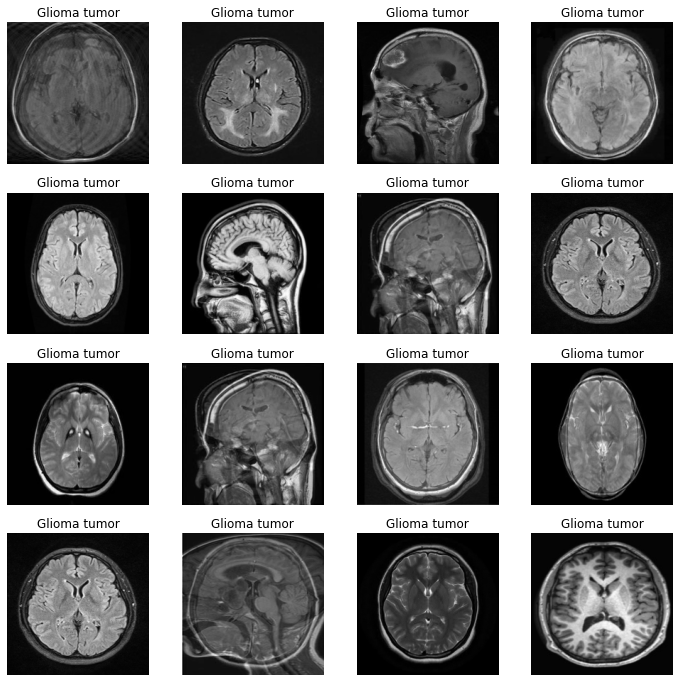

In [53]:
plt.figure(figsize = (12,12))
for i in range(16) :
    plt.subplot(4, 4, i+1)
    x = np.random.randint(2870, 3308)
    plt.imshow(X_train[x].reshape(200,200), 'gray')
    plt.title(meta[np.argmax(y_train[x])])
    plt.axis('off')
plt.show()

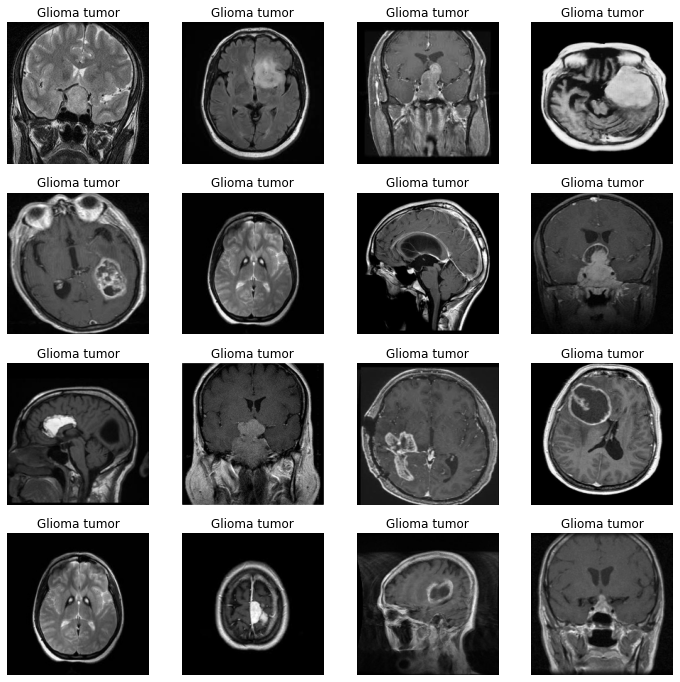

In [54]:
plt.figure(figsize = (12,12))
for i in range(16) :
    plt.subplot(4, 4, i+1)
    x = np.random.randint(0,390)
    plt.imshow(X_test[x].reshape(200,200),'gray')
    plt.title(meta[np.argmax(y_test[x])])
    plt.axis('off')
plt.show()

In [55]:
num_classes = 4
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 100
image_size = 200  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [56]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [57]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [58]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 200 X 200
Patch size: 16 X 16
Patches per image: 144
Elements per patch: 256


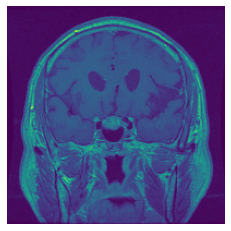

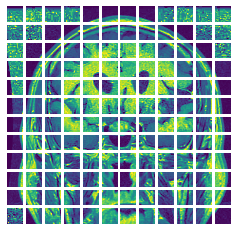

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.reshape(200,200))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

In [60]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [61]:
def create_vit_classifier():
    inputs = layers.Input(shape=(200,200,1))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [62]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/content/drive/My Drive/Colab Notebooks/brain_tumor_mri/checkpoint/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        #save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
47/47 [==============================] - 229s 5s/step - loss: 2.5805 - accuracy: 0.4212 - top-5-accuracy: 1.0000 - val_loss: 1.1393 - val_accuracy: 0.4562 - val_top-5-accuracy: 1.0000
Epoch 2/100
47/47 [==============================] - 218s 5s/step - loss: 1.1576 - accuracy: 0.5328 - top-5-accuracy: 1.0000 - val_loss: 0.6799 - val_accuracy: 0.7704 - val_top-5-accuracy: 1.0000
Epoch 3/100
47/47 [==============================] - 211s 4s/step - loss: 1.0269 - accuracy: 0.5694 - top-5-accuracy: 1.0000 - val_loss: 1.0679 - val_accuracy: 0.6344 - val_top-5-accuracy: 1.0000
Epoch 4/100
47/47 [==============================] - 201s 4s/step - loss: 0.9157 - accuracy: 0.6144 - top-5-accuracy: 1.0000 - val_loss: 1.1374 - val_accuracy: 0.5831 - val_top-5-accuracy: 1.0000
Epoch 5/100
47/47 [==============================] - 194s 4s/step - loss: 0.8845 - accuracy: 0.6292 - top-5-accuracy: 1.0000 - val_loss: 0.9507 - val_accuracy: 0.7100 - val_top-5-accuracy: 1.0000
Epoch 6/100
47/47 [=

In [63]:
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

NameError: ignored